# QB's Accuracy vs QB's Aggressiveness



In this project , I want to see if there is an inverse relationship between a quarterback's accuracy and how aggressive a quarterback will be in terms of average depth of target. I will see using two key stats: Adjust Compeletion Percentage and Average Depth of Target (aDOT). I did retrieve data from PFF Elite Subscription. 

Big shoutout to Tej Seth (https://twitter.com/tejfbanalytics) for all the tutorials and inspiration. Without his resources, I would not have made this. Owe this all to him. Some of the code was used from him too.\

This project is more of me just learning how I can apply analytics coding with Python


I will also create a model to see if there is truly an inverse relationship 

In [299]:
import numpy as np
import pandas as pd
import seaborn as sns
import nflfastpy as nfl
from matplotlib import pyplot as plt

In [300]:
#Import all the play by play data from 2017 to 2021
pbp_2021 = pd.read_csv('passing_summary_2021.csv')
pbp_2020 = pd.read_csv('passing_summary_2020.csv')
pbp_2019 = pd.read_csv('passing_summary_2019.csv')
pbp_2018 = pd.read_csv('passing_summary_2018.csv')
pbp_2017 = pd.read_csv('passing_summary_2017.csv')

qb_2017_2021 = pd.concat([pbp_2021, pbp_2020, pbp_2019, pbp_2018, pbp_2017])

In [301]:
#Create a quarterback data frame for passing report
qb = qb_2017_2021[qb_2017_2021.position == "QB"]
qb

,player,player_id,position,team_name,player_game_count,accuracy_percent,aimed_passes,attempts,avg_depth_of_target,avg_time_to_throw,bats,big_time_throws,btt_rate,completion_percent,completions,declined_penalties,def_gen_pressures,drop_rate,dropbacks,drops,first_downs,franchise_id,grades_hands_fumble,grades_offense,grades_pass,grades_run,hit_as_threw,interceptions,passing_snaps,penalties,pressure_to_sack_rate,qb_rating,sack_percent,sacks,scrambles,spikes,thrown_aways,touchdowns,turnover_worthy_plays,twp_rate,yards,ypa
0,Tom Brady,698,QB,TB,19,76.4,766,810,8.2,2.33,10,44,5.2,67.2,544,0,175,7.0,849,41,303,30,90.5,91.5,90.4,77.5,5,13,881,2,16.6,100.7,3.4,29,10,2,27,46,16,1.8,5916,7.3
1,Patrick Mahomes,11765,QB,KC,20,79.2,708,780,7.4,2.87,6,30,3.6,67.3,525,0,276,6.4,880,36,346,16,47.4,80.4,76.0,84.0,8,16,937,5,13.4,101.6,4.2,37,61,0,58,48,24,2.6,5896,7.6
2,Matthew Stafford,4924,QB,LA,21,76.6,709,741,8.9,2.66,8,47,6.0,67.7,502,0,208,7.6,793,41,296,26,85.9,86.1,84.6,73.9,7,20,831,10,17.8,103.9,4.7,37,15,1,16,50,29,3.5,6074,8.2
3,Josh Allen,46601,QB,BUF,19,74.8,651,708,9.1,2.89,17,44,5.9,64.5,457,0,264,6.2,793,30,287,4,64.9,90.9,81.9,93.6,4,15,843,4,10.6,97.9,3.5,28,55,0,36,45,27,3.2,5044,7.1
4,Derek Carr,8671,QB,LV,18,77.0,631,680,8.4,2.73,10,41,5.7,67.2,457,0,252,6.0,744,29,236,23,57.7,77.6,77.5,54.6,6,15,789,5,17.1,92.0,5.8,43,19,4,29,24,25,3.2,5114,7.5
5,Justin Herbert,28237,QB,LAC,17,77.1,624,672,7.9,2.72,17,27,3.8,65.9,443,0,199,7.9,740,38,273,27,92.6,90.1,86.2,79.1,6,15,793,2,15.6,97.7,4.2,31,36,1,24,38,13,1.6,5014,7.5
6,Joe Burrow,28022,QB,CIN,20,79.8,619,662,8.2,2.62,14,39,5.6,69.9,463,1,260,6.3,759,31,266,7,78.3,91.8,91.1,67.3,3,16,799,4,26.9,105.9,9.2,70,26,3,23,39,17,2.1,5716,8.6
7,Ben Roethlisberger,1732,QB,PIT,17,72.5,626,649,7.1,2.25,12,24,3.4,64.6,419,0,154,7.7,692,35,206,25,28.1,53.0,52.8,52.5,3,10,740,2,26.0,87.2,5.8,40,3,2,6,24,36,4.9,3955,6.1
8,Dak Prescott,10769,QB,DAL,17,76.5,604,639,8.3,2.70,12,34,4.9,67.8,433,0,222,6.3,703,29,244,9,37.0,82.4,83.5,41.6,7,11,760,3,15.8,101.9,5.0,35,24,1,15,38,24,3.2,4703,7.4
9,Trevor Lawrence,77632,QB,JAX,17,72.4,547,602,8.2,2.84,9,22,3.4,59.6,359,0,220,9.3,668,37,187,15,61.8,59.6,58.2,63.6,13,17,709,2,14.5,71.9,4.8,32,33,3,30,12,26,3.7,3641,6.0


In [302]:
#Create a Completion Percentage Table compiled from 2017-2021
qb_comp_calc = qb.groupby(['player', 'player_id'], as_index = False).agg({'aimed_passes': 'sum', 'completions': 'sum', 'attempts':'sum', 'drops': 'sum'})
qb_comp_calc['adjusted_completion_percent'] = (qb_comp_calc['completions'] + qb_comp_calc['drops'])*(100)/(qb_comp_calc['aimed_passes'])
qb_comp = qb_comp_calc[['player', 'player_id', 'attempts', 'adjusted_completion_percent']]

In [303]:
#Create an aDOT Table compiled from 2017-2021
qb_adot_calc = qb[['player', 'player_id', 'attempts', 'avg_depth_of_target']]
qb_adot_calc['air_yards'] = qb_adot_calc['attempts']*qb_adot_calc['avg_depth_of_target']
qb_adot_calc = qb_adot_calc.groupby(['player', 'player_id'], as_index = False).agg({'attempts':'sum', 'air_yards':'sum'})
qb_adot_calc["adot"] = qb_adot_calc["air_yards"]/qb_adot_calc["attempts"]

qb_adot = qb_adot_calc[['player', 'player_id', 'adot']]

<ipython-input-303-0dd33cd9e140>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qb_adot_calc['air_yards'] = qb_adot_calc['attempts']*qb_adot_calc['avg_depth_of_target']


In [304]:
#Join the aDot table and completion percentage table
qb_adot_comp = pd.merge(qb_adot, qb_comp, how='left', left_on='player_id', right_on='player_id')
qb_adot_comp = qb_adot_comp[['player_id', 'player_x', 'adot', 'adjusted_completion_percent', 'attempts']]
qb_adot_comp.columns = qb_adot_comp.columns.str.replace('player_x', 'player')
qb_adot_comp = qb_adot_comp[qb_adot_comp.attempts > 382]
qb_adot_comp = qb_adot_comp.reset_index(drop=True)

In [305]:
teams_colors_logos = nfl.load_team_logo_data()

In [306]:
#Get the QB Team to retrieve the color

qb_team = qb.groupby(['player', 'player_id'], as_index = False).agg({"team_name": lambda x: list(x)})
qb_team["team"] = qb_team["team_name"].str.get(0)

#Some changes for texans and browns abbreviation as it did not align with the spreadsheet
qb_team['team'] = qb_team['team'].replace(['HST', 'CLV', 'ARZ', 'BLT'],['HOU', 'CLE', 'ARI', 'BAL'])

In [307]:
#Join the QB Team and Team Color Table

qb_team_with_color = pd.merge(qb_team, teams_colors_logos, how='left', left_on='team', right_on='team_abbr') 
qb_team_with_color = qb_team_with_color[['player', 'player_id', 'team', 'team_color']]

In [308]:
# Join the QB Team Color and QB ADOT/COMPLETION Table 

qb_final = pd.merge(qb_adot_comp, qb_team_with_color, how="left", left_on="player_id", right_on="player_id")
qb_final = qb_final[['player_id', 'player_x', 'attempts', 'adjusted_completion_percent', 'adot', 'team', 'team_color']]
qb_final.columns = qb_final.columns.str.replace('player_x', 'player')
qb_final = qb_final.reset_index(drop=True)
qb_final['team_color'] = qb_final['team_color'].replace(['nan'],'blue')

# Create a Scatterplot Visualization 

Text(0, 0.5, 'Average Depth of Target (ADOT)')

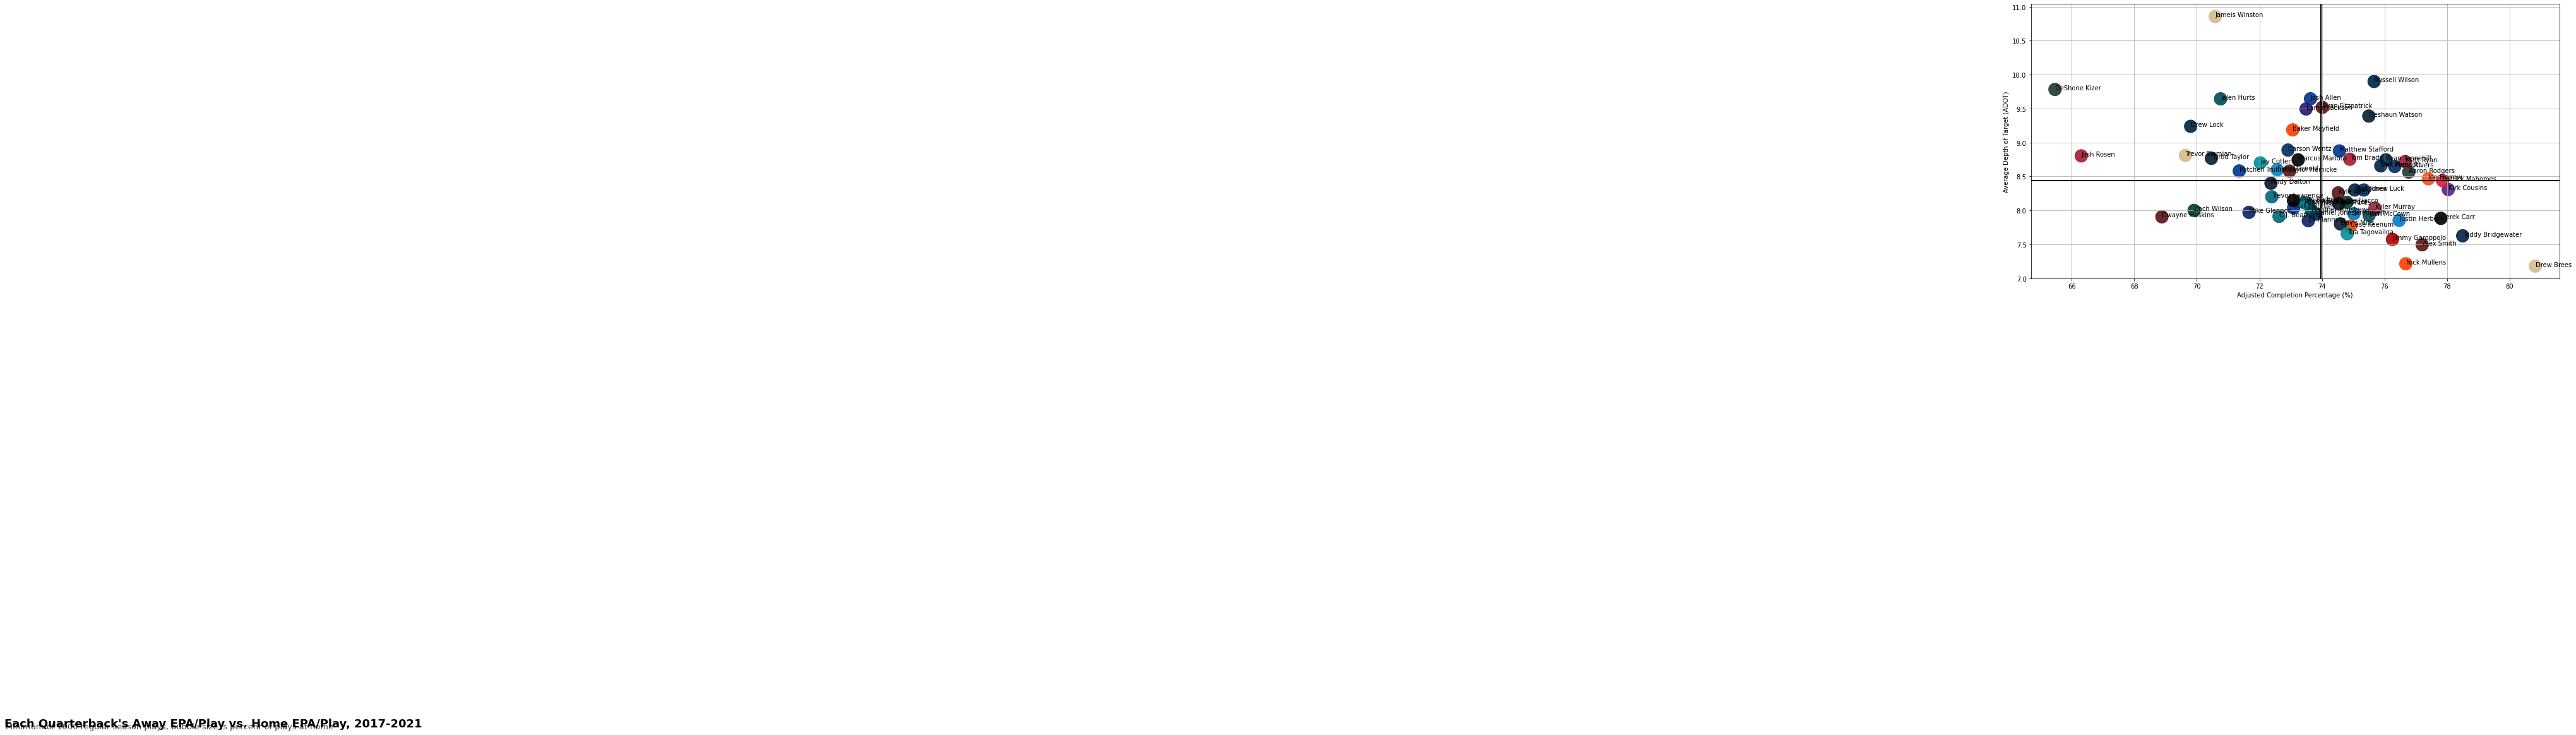

In [311]:
fig, ax = plt.subplots(figsize=(15,8))

ax.axvline(qb_final['adjusted_completion_percent'].mean(), color='black', lw = 2)
ax.axhline(qb_final['adot'].mean(), color='black', lw = 2)

ax.scatter(qb_final['adjusted_completion_percent'], qb_final['adot'], 
           alpha=.9, 
           s = 400,
           color=qb_final.team_color
          )

ax.text(x=-0.06, y=0.36, s="Each Quarterback's Away EPA/Play vs. Home EPA/Play, 2017-2021", fontsize=18, weight='bold', va='bottom')
ax.text(x=-0.03, y=0.34, s='Minimum of 1000 regular season plays, bubble size is percent of plays at home', fontsize=13, alpha=0.75, va='bottom')

for line in range(0, qb_final.shape[0]):
    plt.text(qb_final.adjusted_completion_percent[line]+0.003, qb_final.adot[line]-0.002, qb_final.player[line])
plt.grid()
ax.set_xlabel("Adjusted Completion Percentage (%)")
ax.set_ylabel("Average Depth of Target (ADOT)")

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

ax.axvline(qb_epa['home_epa'].mean(), color='black', lw = 2)
ax.axhline(qb_epa['away_epa'].mean(), color='black', lw = 2)

ax.scatter(qb_epa["home_epa"], qb_epa["away_epa"], 
           alpha=.7, 
           s = qb_epa.home_perc/1.7,
           color=qb_epa.team_color)
ax.text(x=-0.06, y=0.36, s="Each Quarterback's Away EPA/Play vs. Home EPA/Play, 2017-2021", fontsize=18, weight='bold', va='bottom')
ax.text(x=-0.03, y=0.34, s='Minimum of 1000 regular season plays, bubble size is percent of plays at home', fontsize=13, alpha=0.75, va='bottom')
for line in range(0,qb_epa.shape[0]):
    if line == 7:
        pass
    else:
        plt.text(qb_epa.home_epa[line]+0.007, qb_epa.away_epa[line]-0.002, qb_epa.passer[line])
ax.set_xlabel("Home EPA/Play")
ax.text(x = 0.22, y = -0.05, s = "Figure 9")
ax.set_ylabel("Away EPA/Play")